In [1]:
import sys
sys.path.append('./code')
from importlib import reload

In [2]:
from config import row_colors, columns_to_names, row_colors_dict

2


In [3]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

from config import load_pileup_variables

(goodinds, merged_clustdict, merged_inds_to_subset, 
    cooldict_50kb, ind_to_gene, all_ind_to_region, my_treg_comp) = load_pileup_variables()

In [4]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [5]:
from initialize import *

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


#### Pileup of bins with differential metadomain scores

In [6]:
stat_df = pd.read_csv('./diff_ms_dfs/stat_df.csv', index_col = 0)
pval_df = pd.read_csv('./diff_ms_dfs/pval_df.csv', index_col = 0)

diff_inds = stat_df.index[((stat_df.abs() > 1.5) & (pval_df < .01)).any(axis=1)]

In [7]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50

our_treg_25kb = cooler.Cooler('./Treg_all.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/25000')

metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

df1 = pd.DataFrame()
df1['ind'] = diff_inds
df1['chrom'] = [all_ind_to_region[x][0] for x in df1['ind']]
df1['cluster'] = -1

df2 = pd.DataFrame()
df2['ind'] = goodinds
df2['chrom'] = [all_ind_to_region[x][0] for x in goodinds]
df2['cluster'] = merged_clustdict['all']
df2 = df2[df2['cluster'].isin([0, 4, 18])]

differential_mat_dict, differential_metadata = pileup_bin_pairs(df1, df2, metadomain_pileup_cooldict,
                                                                chrom_to_start, None, 
                                                                None, resolution_in = 250_000, 
                                                                resolution_out = 25_000, 
                                                                intra = False, inter = True, 
                                                                padding_size = padding_size,
                                                                fetch_oe = True,
                                                                skip_metadomains = True,
                                                               )

Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 13
Done with 13
Done with 13
Done with 1

Pileup of bins with Treg-Up

(372,)
(284,)
(148,)


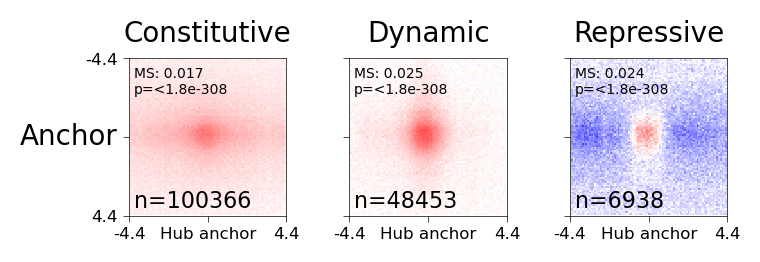

In [8]:
from hub_pileup import plot_pileup_mat

# name = get_name(ind, ind_to_gene)
fig, axs = init_subplots_exact(3, 1, fgsz=(20*mm, 20*mm), dpi = 100, xspace=1.4)
for c, cluster in enumerate([0, 4, 18]):
    plt.sca(axs[c])
    idx = ( (
               (stat_df.loc[differential_metadata['ind1'].values][str(cluster)] > 1.5).values
             & (pval_df.loc[differential_metadata['ind1'].values][str(cluster)] < .01).values
             & (differential_metadata['cluster2']==cluster).values
            ) 
          )
    print(differential_metadata[(stat_df.loc[differential_metadata['ind1'].values][str(cluster)] > 1.5).values
          &(pval_df.loc[differential_metadata['ind1'].values][str(cluster)] < .01).values]['ind1'].unique().shape)
    rows = []

    mats = (differential_mat_dict['Our_Treg'][idx] - differential_mat_dict['Our_Tcon'][idx])[:, 8:, 8:]
    plot_pileup_mat(mats,  plt.gca(), cmap = 'bwr', vmin = -.05, vmax = .05, center=4,
                       s2=-1)
    plt.title(columns_to_names[cluster])
    plt.grid(False)


    
n = mats.shape[1]
cutoff = n*50_000/1e6
mb = mats.shape[1]*50e3 // 2 / 1e6

for c, a in enumerate(axs):
    plt.sca(axs[c])

    plt.yticks([-mb, 0, mb])
    plt.gca().set_yticklabels([-cutoff, 'Anchor', cutoff])
    plt.gca().get_yticklabels()[1].set_fontsize(10)
    plt.gca().get_yticklabels()[1].set_rotation(0)
    plt.gca().get_yticklabels()[1].set_va('center')

    plt.gca().set_xticks([-mb, 0, mb])
    plt.gca().set_xticklabels([-cutoff, "Hub anchor", cutoff])

    a.tick_params(labeltop = False, top = False, labelbottom = True, bottom = True)
    if c % n != 0 :
        plt.gca().tick_params(labelleft=False)

fig.savefig('./plots/paper/fig4/treg_up_ms.pdf', bbox_inches='tight')

Pileup of bins with Treg-down

(612,)
(752,)
(130,)


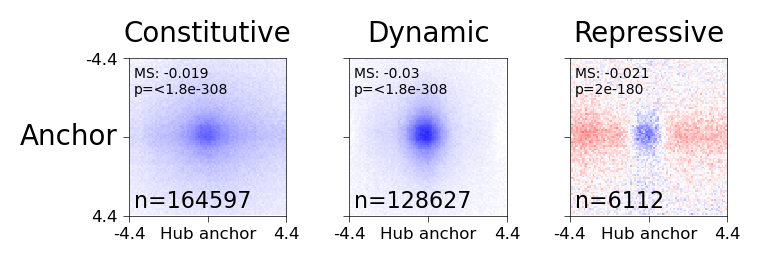

In [9]:
from hub_pileup import plot_pileup_mat

# name = get_name(ind, ind_to_gene)
fig, axs = init_subplots_exact(3, 1, fgsz=(20*mm, 20*mm), dpi = 100, xspace=1.4)
for c, cluster in enumerate([0, 4, 18]):
    plt.sca(axs[c])
    idx = ( (
               (stat_df.loc[differential_metadata['ind1'].values][str(cluster)] < -1.5).values
             & (pval_df.loc[differential_metadata['ind1'].values][str(cluster)] < .01).values
             & (differential_metadata['cluster2']==cluster).values
            ) 
          )
    print(differential_metadata[(stat_df.loc[differential_metadata['ind1'].values][str(cluster)] < -1.5).values
          &(pval_df.loc[differential_metadata['ind1'].values][str(cluster)] < .01).values]['ind1'].unique().shape)
    rows = []

    mats = (differential_mat_dict['Our_Treg'][idx] - differential_mat_dict['Our_Tcon'][idx])[:, 8:, 8:]
    plot_pileup_mat(mats,  plt.gca(), cmap = 'bwr', vmin = -.05, vmax = .05, center=4,
                   s2=-1)
    plt.title(columns_to_names[cluster])
    plt.grid(False)


    
n = mats.shape[1]
cutoff = n*50_000/1e6
mb = mats.shape[1]*50e3 // 2 / 1e6

for c, a in enumerate(axs):
    plt.sca(axs[c])

    plt.yticks([-mb, 0, mb])
    plt.gca().set_yticklabels([-cutoff, 'Anchor', cutoff])
    plt.gca().get_yticklabels()[1].set_fontsize(10)
    plt.gca().get_yticklabels()[1].set_rotation(0)
    plt.gca().get_yticklabels()[1].set_va('center')

    plt.gca().set_xticks([-mb, 0, mb])
    plt.gca().set_xticklabels([-cutoff, "Hub anchor", cutoff])

    a.tick_params(labeltop = False, top = False, labelbottom = True, bottom = True)
    if c % n != 0 :
        plt.gca().tick_params(labelleft=False)

fig.savefig('./plots/paper/fig4/treg_down_ms.pdf', bbox_inches='tight')

Pileup of bins with No Effect

In [10]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50

our_treg_25kb = cooler.Cooler('./Treg_all.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/25000')

metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

df1 = pd.DataFrame()
df1['ind'] = stat_df.index
df1['chrom'] = [all_ind_to_region[x][0] for x in df1['ind']]
df1['cluster'] = -1

df2 = pd.DataFrame()
df2['ind'] = goodinds
df2['chrom'] = [all_ind_to_region[x][0] for x in goodinds]
df2['cluster'] = merged_clustdict['all']
df2 = df2[df2['cluster'].isin([0, 4, 18])]

ns_mat_dict, ns_metadata = pileup_bin_pairs(df1, df2, metadomain_pileup_cooldict,
                                                                chrom_to_start, None, 
                                                                None, resolution_in=250_000, 
                                                                resolution_out = 25_000, 
                                                                intra=False, inter=True, padding_size=padding_size, fetch_oe=True,
                                                                skip = 10, skip_metadomains=True,
                                                               )

Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 10
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 9
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 16
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 4
Done with 13
Done with 13
Done with 13
Done with 1

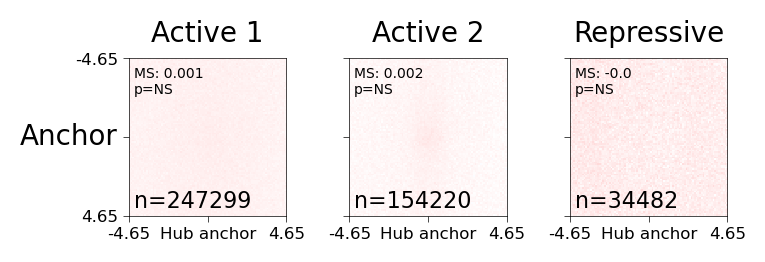

In [109]:
from hub_pileup import plot_pileup_mat

# name = get_name(ind, ind_to_gene)
fig, axs = init_subplots_exact(3, 1, fgsz=(20*mm, 20*mm), dpi = 100, xspace=1.4)
for c, cluster in enumerate([0, 4, 18]):
    plt.sca(axs[c])
    idx = ( ((stat_df.loc[ns_metadata['ind1'].values][str(cluster)].abs() < 1.5
             ).values & (ns_metadata['cluster2']==cluster).values) 
          )
    rows = []

    mats = (ns_mat_dict['Our_Treg'][idx] - ns_mat_dict['Our_Tcon'][idx])[:, 8:, 8:]
    plot_pileup_mat(mats,  plt.gca(), cmap = 'bwr', vmin = -.05, vmax = .05, center=4, delta_co=.005)
    plt.title(columns_to_names[cluster])
    plt.grid(False)

    
n = mats.shape[1]
cutoff = n*50_000/1e6
mb = mats.shape[1]*50e3 // 2 / 1e6

for c, a in enumerate(axs):
    plt.sca(axs[c])

    plt.yticks([-mb, 0, mb])
    plt.gca().set_yticklabels([-cutoff, 'Anchor', cutoff])
    plt.gca().get_yticklabels()[1].set_fontsize(10)
    plt.gca().get_yticklabels()[1].set_rotation(0)
    plt.gca().get_yticklabels()[1].set_va('center')

    plt.gca().set_xticks([-mb, 0, mb])
    plt.gca().set_xticklabels([-cutoff, "Hub anchor", cutoff])

    a.tick_params(labeltop = False, top = False, labelbottom = True, bottom = True)
    if c % n != 0 :
        plt.gca().tick_params(labelleft=False)

fig.savefig('./plots/paper/fig4/treg_ns_ms.pdf', bbox_inches='tight')